In [1]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common.reaction import Reaction
from SBMLLint.games.som import SOM
from SBMLLint.common.simple_sbml import SimpleSBML

import collections
import copy
import itertools
import networkx as nx
import numpy as np
import pandas as pd
#
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix
from SBMLLint.games.mesgraph import MESGraph
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ReactionOperation = collections.namedtuple("ReactionOperation", 
    "reaction operation")

Current Directory: /Users/woosubshin/Desktop/ModelEngineering/SBMLLint/notebook


In [2]:
# statistics columns
MODEL_ID = "model_id"
NUM_TOTAL_REACTIONS = "num_total_reactions"
NUM_NONBDRY_REACTIONS = "num_nonbdry_reactions"
NUM_MULTIMULTI_REACTIONS = "num_multimulti_reactions"
#
ERROR_TYPE = "error_type"
TYPE_I = "type1"
TYPE_II = "type2"
TYPE_III = "type3"
CANCELING = "canceling"
ECHELON = "echelon"
ERRORS = [TYPE_I, TYPE_II, TYPE_III, CANCELING, ECHELON]
#
NUM_ERROR_REACTIONS = "num_error_reactions"

In [3]:
data_dir=cn.BIOMODELS_DIR
#files = [f for f in os.listdir(data_dir) if f[-4:] == ".xml"]
files = [f for f in os.listdir(data_dir) if f[:7] == "BIOMD00"]
#paths = [os.path.join(data_dir, filename) for filename in files]
unloadable_models = ["BIOMD0000000075_url.xml",
                     "BIOMD0000000081_url.xml",
                     "BIOMD0000000094_url.xml",
                     "BIOMD0000000353_url.xml",
                     "BIOMD0000000596_url.xml"]
net_files = list(set(files) - set(unloadable_models))

In [4]:
len(net_files)

651

In [5]:
ErrorSummary = collections.namedtuple("ErrorSummary",
    "type1 type2 type3 canceling echelon")
a = ErrorSummary(type1 = 1, type2 = 2, type3 = 3, canceling=4, echelon=5)
a

ErrorSummary(type1=1, type2=2, type3=3, canceling=4, echelon=5)

In [6]:
simple = SimpleSBML()
simple.initialize(os.path.join(data_dir, files[1]))
s = StoichiometryMatrix(simple)
num_total_reactions = len(simple.reactions)
num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
print(num_total_reactions)
print(num_nonbdry_reactions)
m = GAMES_PP(simple)
if simple.reactions:
  result = m.analyze(error_details=False)
  if result:
    dic = {}
    dic[MODEL_ID] = files[0]
    dic[NUM_TOTAL_REACTIONS] = num_total_reactions
    dic[NUM_NONBDRY_REACTIONS] = num_nonbdry_reactions
    summary = m.error_summary
    if summary[0].type == TYPE_I:
      print("type1 error")
    if summary[0].type == TYPE_II:
      print("type2 error")

14
13
type1 error


In [7]:
# Checking all graphs 
count = 0
simple = SimpleSBML()
res_list = []
false_errors = set()
for file in net_files:
  count += 1
  if (count%100)==0:
    print("we are analyzing Model number:", count)
  try:
    simple.initialize(os.path.join(data_dir, file))
    m = GAMES_PP(simple)
    s = StoichiometryMatrix(simple)
    num_total_reactions = len(simple.reactions)
    num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
    if simple.reactions:
      result = m.analyze(error_details=False)
      if result:
        gr = GAMESReport(m)
        errortype_dic = {TYPE_I: gr.reportTypeOneError,
                         TYPE_II: gr.reportTypeTwoError,
                         TYPE_III: gr.reportTypeThreeError,
                         CANCELING: gr.reportCancelingError,
                         ECHELON: gr.reportEchelonError
                        }
        summary = m.error_summary
        for errors in m.error_summary:
          for category in errortype_dic.keys():
            if errors.type == category:
              func = errortype_dic[category]            
              report, error_num = func(errors.errors)
              if report is False:
                false_errors.add(file)
              else:
                for num in error_num:
                  res_list.append(dict({MODEL_ID: file[:-8],
                                        NUM_TOTAL_REACTIONS: num_total_reactions,
                                        NUM_NONBDRY_REACTIONS: num_nonbdry_reactions,
                                        ERROR_TYPE: category,
                                        NUM_ERROR_REACTIONS: num})) 
#                 print("Model ID", file[:-8])
#                 print("error_num", error_num)
  except:
    print("Model", file, " has an error")
print("Models with False Errors", false_errors)
print("Must remove other errors from these models before summarizing")

we are analyzing Model number: 100
we are analyzing Model number: 200
we are analyzing Model number: 300
we are analyzing Model number: 400
we are analyzing Model number: 500
we are analyzing Model number: 600
Models with False Errors {'BIOMD0000000243_url.xml', 'BIOMD0000000628_url.xml'}
Must remove other errors from these models before summarizing


In [8]:
res_df = pd.DataFrame(res_list)
res_df.head()d

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
0,type1,BIOMD0000000587,1,16,23
1,type1,BIOMD0000000587,1,16,23
2,type1,BIOMD0000000587,1,16,23
3,type1,BIOMD0000000587,1,16,23
4,type1,BIOMD0000000587,1,16,23


In [110]:
res_df[res_df[MODEL_ID] == "BIOMD0000000574"]

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions


In [111]:
filtered_df = res_df[(res_df[MODEL_ID] != "BIOMD0000000243") &
                    (res_df[MODEL_ID] != "BIOMD0000000628")]

In [112]:
len(set(filtered_df[MODEL_ID]))

136

In [113]:
# niss: normalized isolation set size
extended_res_df = filtered_df.assign(niss = filtered_df[NUM_ERROR_REACTIONS] / filtered_df[NUM_NONBDRY_REACTIONS])
extended_res_df.head()

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions,niss
0,type1,BIOMD0000000587,1,16,23,0.0625
1,type1,BIOMD0000000587,1,16,23,0.0625
2,type1,BIOMD0000000587,1,16,23,0.0625
3,type1,BIOMD0000000587,1,16,23,0.0625
4,type1,BIOMD0000000587,1,16,23,0.0625


In [131]:
len(extended_res_df)

847

In [135]:
print("Average ISS for GAMES+: \n%f" % np.mean(extended_res_df[NUM_ERROR_REACTIONS]))
print("Standard Error of ISS for GAMES+: \n%f" % 
      (np.std(extended_res_df[NUM_ERROR_REACTIONS])/np.sqrt(len(extended_res_df))))
print("Average nISS for GAMES+: \n%f" % np.mean(extended_res_df["niss"]))
print("Standard Error of nISS for GAMES+: \n%f" % 
      ( np.std(extended_res_df["niss"]) / np.sqrt(len(extended_res_df)) ))

Average ISS for GAMES+: 
4.003542
Standard Error of ISS for GAMES+: 
0.340206
Average nISS for GAMES+: 
0.085472
Standard Error of nISS for GAMES+: 
0.004562


In [79]:
len(extended_res_df)

847

In [81]:
extended_res_df[extended_res_df[MODEL_ID] == "BIOMD0000000628"]

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions,niss


In [84]:
simple_games_res_df = extended_res_df[(extended_res_df[ERROR_TYPE]==TYPE_I) | (extended_res_df[ERROR_TYPE]==TYPE_II)]
simple_games_res_df.head()

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions,niss
0,type1,BIOMD0000000587,1,16,23,0.0625
1,type1,BIOMD0000000587,1,16,23,0.0625
2,type1,BIOMD0000000587,1,16,23,0.0625
3,type1,BIOMD0000000587,1,16,23,0.0625
4,type1,BIOMD0000000587,1,16,23,0.0625


In [142]:
a = np.std(simple_games_res_df["niss"])
b = np.sqrt(len(simple_games_res_df))
a / b

0.004497613772750082

In [141]:
print("Average ISS for Simple GAMES: \n%f" % np.mean(simple_games_res_df[NUM_ERROR_REACTIONS]))
print("Standard Deviation of ISS for sGAMES: \n%f" % 
      (np.std(simple_games_res_df[NUM_ERROR_REACTIONS]) / np.sqrt(len(simple_games_res_df))))
print("Average NISS for Simple GAMES+: \n%f" % np.mean(simple_games_res_df["niss"]))
print("Standard Deviation of nISS for sGAMES: \n%f" % 
      (np.std(simple_games_res_df["niss"]) / np.sqrt(len(simple_games_res_df))))

Average ISS for Simple GAMES: 
3.845269
Standard Deviation of ISS for sGAMES: 
0.365859
Average NISS for Simple GAMES+: 
0.075807
Standard Deviation of nISS for sGAMES: 
0.004498


In [86]:
res_df[res_df[NUM_ERROR_REACTIONS] > res_df[NUM_NONBDRY_REACTIONS]]

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions


In [87]:
len(extended_res_df)

847

In [88]:
len(simple_games_res_df)

782

In [50]:
dd = extended_res_df[(extended_res_df[ERROR_TYPE]==TYPE_III) | \
                     (extended_res_df[ERROR_TYPE]==CANCELING) | \
                    (extended_res_df[ERROR_TYPE]==ECHELON)]

In [51]:
np.mean(dd[NUM_ERROR_REACTIONS])

29.65024630541872

(array([47.,  2., 22., 62., 69.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2. , 11.5, 21. , 30.5, 40. , 49.5, 59. , 68.5, 78. , 87.5, 97. ]),
 <a list of 10 Patch objects>)

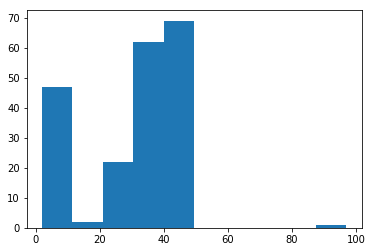

In [52]:
plt.hist(dd[NUM_ERROR_REACTIONS])

In [62]:
extended_res_df.head()

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions,niss
0,type1,BIOMD0000000189,1,13,14,0.076923
1,type1,BIOMD0000000189,1,13,14,0.076923
2,type1,BIOMD0000000189,1,13,14,0.076923
3,type1,BIOMD0000000189,3,13,14,0.230769
4,type1,BIOMD0000000413,3,5,9,0.600000


In [127]:
len(final_res_df)

847

In [128]:
final_res_df = extended_res_df.rename(columns = {NUM_ERROR_REACTIONS:"iss"})
final_res_df.head()

,error_type,model_id,iss,num_nonbdry_reactions,num_total_reactions,niss
0,type1,BIOMD0000000587,1,16,23,0.0625
1,type1,BIOMD0000000587,1,16,23,0.0625
2,type1,BIOMD0000000587,1,16,23,0.0625
3,type1,BIOMD0000000587,1,16,23,0.0625
4,type1,BIOMD0000000587,1,16,23,0.0625


In [129]:
final_res_df.to_csv("/Users/woosubshin/Desktop/ModelEngineering/results/games_statistics.csv", index=False)

In [93]:
print("Number of models with errors: %d" % (len(set(res_df[MODEL_ID]))))

Number of models with errors: 138


In [71]:
# plt.scatter(res_df[NUM_TOTAL_REACTIONS], res_df[NUM_ERROR_REACTIONS])

In [72]:
# plt.hist(res_df[NUM_TOTAL_REACTIONS] - res_df[NUM_NONBDRY_REACTIONS], bins=100)

In [73]:
# plt.scatter(res_df[NUM_NONBDRY_REACTIONS], res_df[NUM_ERROR_REACTIONS])

In [74]:
type1_res_df = res_df[res_df[ERROR_TYPE] == TYPE_I]
type2_res_df = res_df[res_df[ERROR_TYPE] == TYPE_II]
type3_res_df = res_df[res_df[ERROR_TYPE] == TYPE_III]
canceling_res_df = res_df[res_df[ERROR_TYPE] == CANCELING]
echelon_res_df = res_df[res_df[ERROR_TYPE] == ECHELON]

In [75]:
# type1_res_df.head()

In [76]:
#plt.scatter(type1_res_df[NUM_NONBDRY_REACTIONS], type1_res_df[NUM_ERROR_REACTIONS])

In [77]:
#plt.scatter(type2_res_df[NUM_NONBDRY_REACTIONS], type2_res_df[NUM_ERROR_REACTIONS])

In [78]:
#plt.scatter(type3_res_df[NUM_NONBDRY_REACTIONS], type3_res_df[NUM_ERROR_REACTIONS])

In [79]:
#plt.scatter(canceling_res_df[NUM_NONBDRY_REACTIONS], canceling_res_df[NUM_ERROR_REACTIONS])

In [80]:
#plt.scatter(echelon_res_df[NUM_NONBDRY_REACTIONS], echelon_res_df[NUM_ERROR_REACTIONS])

In [28]:
#res_list

In [94]:
prop = filtered_df["num_error_reactions"] / filtered_df["num_nonbdry_reactions"]
error_prop = prop[prop > 1]
nonerror_prop = prop[prop<=1]
print("error_prop", error_prop)

error_prop Series([], dtype: float64)


Text(0, 0.5, 'Cumulative Probability')

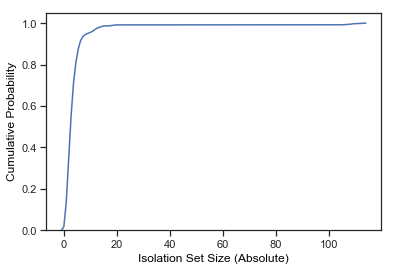

In [95]:
sns.set(style="white",
        font='Times New Roman',
        rc={'figure.figsize':(6,4)})
sns.set_style("ticks")
cdf_abs = sns.distplot(final_res_df["iss"],
             hist=False,
             kde_kws=dict(cumulative=True))
plt.xlabel("Isolation Set Size (Absolute)", color="black")
plt.ylabel("Cumulative Probability", color="black")

In [96]:
output_cdf_abs = cdf_abs.get_figure()
output_cdf_abs.savefig("/Users/woosubshin/Desktop/ModelEngineering/figures_tables/cdf_abs.png")

Text(0, 0.5, 'Cumulative Probability')

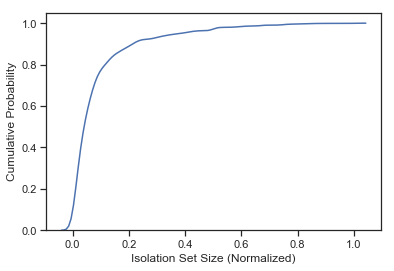

In [97]:
cdf_norm = sns.distplot(final_res_df["niss"], hist=False, kde_kws=dict(cumulative=True))
plt.xlabel("Isolation Set Size (Normalized)")
plt.ylabel("Cumulative Probability")

In [98]:
output_cdf_norm = cdf_norm.get_figure()
output_cdf_norm.savefig("/Users/woosubshin/Desktop/ModelEngineering/figures_tables/cdf_norm.png")

Text(0, 0.5, 'Frequency')

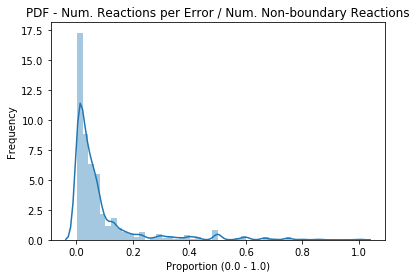

In [33]:
sns.distplot(prop,
             hist_kws=dict(cumulative=False),
             kde_kws=dict(cumulative=False))
plt.title("PDF - Num. Reactions per Error / Num. Non-boundary Reactions")
plt.xlabel("Proportion (0.0 - 1.0)")
plt.ylabel("Frequency")

Text(0, 0.5, 'Cumulative probability')

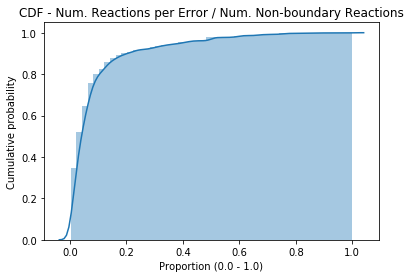

In [34]:
sns.distplot(prop,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
plt.title("CDF - Num. Reactions per Error / Num. Non-boundary Reactions")
plt.xlabel("Proportion (0.0 - 1.0)")
plt.ylabel("Cumulative probability")

Text(0, 0.5, 'Probability')

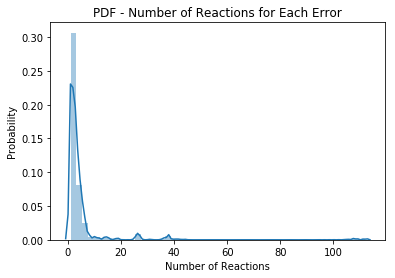

In [41]:
sns.distplot(res_df[NUM_ERROR_REACTIONS],
             hist_kws=dict(cumulative=False),
             kde_kws=dict(cumulative=False))
plt.title("PDF - Number of Reactions for Each Error")
plt.xlabel("Number of Reactions")
plt.ylabel("Probability")

Text(0, 0.5, 'Cumulative probability')

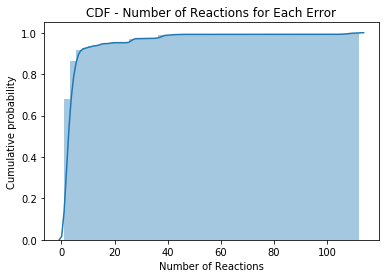

In [39]:
sns.distplot(res_df[NUM_ERROR_REACTIONS],
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True))
plt.title("CDF - Number of Reactions for Each Error")
plt.xlabel("Number of Reactions")
plt.ylabel("Cumulative probability")

In [49]:
len(res_df[res_df[NUM_ERROR_REACTIONS] <= 3]) / len(res_df[NUM_ERROR_REACTIONS])

0.6804123711340206

In [51]:
len(res_df[NUM_ERROR_REACTIONS])

873

In [55]:
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 3]))
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 3]) / len(res_df[NUM_ERROR_REACTIONS]))

594
0.6804123711340206


In [56]:
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 5]))
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 5]) / len(res_df[NUM_ERROR_REACTIONS]))

752
0.861397479954181


In [57]:
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 10]))
print(len(res_df[res_df[NUM_ERROR_REACTIONS] <= 10]) / len(res_df[NUM_ERROR_REACTIONS]))

813
0.9312714776632303


In [71]:
res_df.loc[170:180]

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
170,type1,BIOMD0000000297,4,22,51
171,type1,BIOMD0000000297,5,22,51
172,type1,BIOMD0000000356,5,63,64
173,type1,BIOMD0000000356,6,63,64
174,type1,BIOMD0000000356,6,63,64
175,type1,BIOMD0000000356,6,63,64
176,type1,BIOMD0000000356,7,63,64
177,echelon,BIOMD0000000426,3,29,29
178,echelon,BIOMD0000000426,8,29,29
179,echelon,BIOMD0000000105,3,94,94


In [38]:
for i, m in enumerate(files):
  if m[:-8] == "BIOMD0000000014":
    print("index of model 14 is", i)

index of model 14 is 157


In [39]:
files[156]

'BIOMD0000000362_url.xml'

In [61]:
import time
# Checking all graphs 
simple = SimpleSBML()
count = 0
res_list2 = []
start = time.time()
for file in files[140:170]:
  count += 1
  if (count%100)==0:
    print("we are analyzing Model number:", count)
  try:
    simple.initialize(os.path.join(data_dir, file))
    m = GAMES_PP(simple)
    s = StoichiometryMatrix(simple)
    num_total_reactions = len(simple.reactions)
    num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
    if simple.reactions:
      result = m.analyze(error_details=False)
      if result:
        gr = GAMESReport(m)
        errortype_dic = {TYPE_I: gr.reportTypeOneError,
                         TYPE_II: gr.reportTypeTwoError,
                         TYPE_III: gr.reportTypeThreeError,
                         CANCELING: gr.reportCancelingError,
                         ECHELON: gr.reportEchelonError
                        }
        summary = m.error_summary
        for errors_type in m.error_summary:
          for category in errortype_dic.keys():
            if errors_type.type == category:
              func = errortype_dic[category]            
              _, error_num = func(errors_type.errors)
              for num in error_num:
                dic = {}
                dic[MODEL_ID] = file[:-8]
                dic[NUM_TOTAL_REACTIONS] = num_total_reactions
                dic[NUM_NONBDRY_REACTIONS] = num_nonbdry_reactions
                dic[ERROR_TYPE] = category
                dic[NUM_ERROR_REACTIONS] = num
                res_list2.append(dic)
#                 res_list2.append({MODEL_ID: file[:-8],
#                                   NUM_TOTAL_REACTIONS: num_total_reactions,
#                                   NUM_NONBDRY_REACTIONS: num_nonbdry_reactions,
#                                   ERROR_TYPE: category,
#                                   NUM_ERROR_REACTIONS: num})
#                 print("model dic number", dic[MODEL_ID])
#                 print("res_dic", res_dic)
  except:
    print("Model", file, " has an error")
end = time.time()
print("elapsed time:", end - start)

elapsed time: 3.8915278911590576


In [121]:
filtered_df[filtered_df[ERROR_TYPE]==TYPE_I]

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
0,type1,BIOMD0000000587,1,16,23
1,type1,BIOMD0000000587,1,16,23
2,type1,BIOMD0000000587,1,16,23
3,type1,BIOMD0000000587,1,16,23
4,type1,BIOMD0000000587,1,16,23
5,type1,BIOMD0000000587,1,16,23
7,type1,BIOMD0000000542,2,82,84
8,type1,BIOMD0000000542,2,82,84
13,type1,BIOMD0000000035,1,12,16
14,type1,BIOMD0000000035,1,12,16
